In [1]:
import seaborn as sn
from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score, precision_recall_curve, average_precision_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader, random_split
from torch import Tensor
from torch.nn import Linear, ReLU, Sigmoid, Module, BCELoss, BCEWithLogitsLoss
from torch.optim import Adam
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pandas import DataFrame
import xlsxwriter
import time

seed_value = 7
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import torch
torch.manual_seed(seed_value)

In [2]:
Training_Data = pd.ExcelFile("Training Data.xlsx") #Training Data already pre-scaled to the IBIS Data set
Label_Data = pd.ExcelFile("Labels.xlsx") #Labels
data = Training_Data.parse(Training_Data.sheet_names[0])
label_data = Label_Data.parse(Label_Data.sheet_names[0])
data_features = data.loc[:, data.columns]
data_features = data_features.drop(['ROI','MATCH DEMOS','INDEX SEX','MATCH BASC2','INDEX GA', 'ATP', 'INDEX MEDU', 'MATCH DEMOS OLD', 'INDEX AGE'], axis=1)
data_features = data_features.dropna()
data_features = data_features.drop(['HYP'], axis=1)
labels = label_data.loc[:, label_data.columns]
labels = labels.drop(['ROI','MATCH BASC2', 'INDEX ATP', 'INDEX HYP', 'ATP'], axis=1)
labels = labels.dropna()
print(data_features.shape)
print(labels.shape)

(148, 300)
(148, 1)


In [3]:
twin_data = Training_Data.parse(Training_Data.sheet_names[2])
label_twin_data = Label_Data.parse(Label_Data.sheet_names[2])
twin_data_features = twin_data.loc[:, twin_data.columns]
twin_data_features = twin_data_features.drop(['ROI','MATCH DEMOS','INDEX SEX','MATCH BASC2','INDEX GA', 'ATP', 'INDEX MEDU', 'MATCH DEMOS OLD', 'INDEX AGE'], axis=1)
twin_data_features = twin_data_features.dropna()
twin_data_features = twin_data_features.drop(['HYP'], axis=1)
twin_labels = label_twin_data.loc[:, label_twin_data.columns]
twin_labels = twin_labels.drop(['ROI','MATCH BASC2', 'INDEX ATP', 'INDEX HYP', 'ATP'], axis=1)
twin_labels = twin_labels.dropna()
print(twin_data_features.shape)
print(twin_labels.shape)

#Grab every other row so as to not get both twins
twin_data_features = twin_data_features.iloc[::2, :]
twin_labels = twin_labels.iloc[::2, :]
print(twin_data_features.shape)
print(twin_labels.shape)

(155, 300)
(155, 1)
(78, 300)
(78, 1)


In [4]:
interpolated_data = Training_Data.parse(Training_Data.sheet_names[5])
interpolated_data_features = interpolated_data.loc[:, interpolated_data.columns]
interpolated_data_features = interpolated_data_features.drop(['ROI','MATCH DEMOS','INDEX SEX','MATCH BASC2','INDEX GA', 'ATP', 'ATP Label', 'HYP Label', 'INDEX MEDU'], axis=1)
interpolated_data_features = interpolated_data_features.dropna()
interpolated_data_features = interpolated_data_features.drop(['HYP'], axis=1)

interpolated_label_data = Label_Data.parse(Label_Data.sheet_names[4])
interpolated_labels = interpolated_label_data.loc[:, interpolated_label_data.columns]
interpolated_labels = interpolated_labels.drop(['ROI','ATP'], axis=1)
interpolated_labels = interpolated_labels.dropna()

print(interpolated_data_features.shape)
print(interpolated_labels.shape)
print(type(interpolated_data_features))

(34, 300)
(34, 1)
<class 'pandas.core.frame.DataFrame'>


In [5]:
data_1y = [data_features, twin_data_features]
labels_1y = [labels, twin_labels]

data_features = pd.concat(data_1y)
labels = pd.concat(labels_1y)

print(data_features.shape)
print(labels.shape)

(226, 300)
(226, 1)


In [6]:
skf = StratifiedKFold(n_splits=8)
skf.get_n_splits(data_features, labels)
print(skf)

training_indices_X = []
testing_indices_X = []
training_indices_Y = []
testing_indices_Y = []

for train_index, test_index in skf.split(data_features, labels):
  
    X_train, X_test = data_features.iloc[train_index], data_features.iloc[test_index]
    Y_train, Y_test = labels.iloc[train_index], labels.iloc[test_index]
   
    sm = SMOTE(sampling_strategy = 'minority', random_state = seed_value, k_neighbors=2) 
    X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train) #Only smote the training set.
    print(X_train_res.shape)
    training_indices_X.append(X_train_res)
    testing_indices_X.append(X_test)
    training_indices_Y.append(Y_train_res)
    testing_indices_Y.append(Y_test)


StratifiedKFold(n_splits=8, random_state=None, shuffle=False)
(354, 300)
(354, 300)
(354, 300)
(356, 300)
(356, 300)
(356, 300)
(356, 300)
(356, 300)


In [7]:
training_indices_X[0].head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,SEX,Gestational Age,Maternal Education MEDU,Age at MRI 1
0,-0.260603,-0.074447,0.123098,0.110227,-0.277062,0.287692,0.206996,-0.073593,0.111419,-0.033235,...,0.328442,0.554984,0.467020,0.113749,0.363633,0.324901,1.0,0.666667,8.0,1.073973
1,-0.116665,-0.053437,0.092206,0.146712,-0.213654,0.319648,0.178145,-0.276711,0.243473,0.304333,...,0.256893,0.222129,0.415340,0.252474,0.669453,0.370307,1.0,0.666667,8.0,1.052055
2,0.005308,-0.060916,0.193935,0.092845,-0.086244,0.312178,0.034798,-0.244214,0.114453,0.203349,...,0.236034,0.402563,0.560475,0.532426,0.358366,0.435519,0.0,0.916667,15.0,0.978082
3,-0.162115,-0.159799,0.186191,0.125560,-0.179891,0.420484,0.087587,-0.073629,0.276718,0.064749,...,0.190745,0.421105,0.258039,0.335113,0.438831,0.098697,1.0,0.750000,16.0,1.054795
4,-0.101819,-0.008209,0.373775,0.071498,-0.014684,0.598363,0.292339,-0.139739,0.062950,-0.127031,...,0.260455,0.132798,0.142365,0.470704,0.228815,0.335065,1.0,0.750000,16.0,1.104110


In [8]:
for x in training_indices_X:
    print(x.shape)
    
#Figure out how to loop this later. Wasn't working for the following code:
#for x in training_indices_X:
#    x = pd.concat([x,interpolated_data_features])

training_indices_X[0] = pd.concat([training_indices_X[0],interpolated_data_features])
training_indices_X[1] = pd.concat([training_indices_X[1],interpolated_data_features])
training_indices_X[2] = pd.concat([training_indices_X[2],interpolated_data_features])
training_indices_X[3] = pd.concat([training_indices_X[3],interpolated_data_features])
training_indices_X[4] = pd.concat([training_indices_X[4],interpolated_data_features])
training_indices_X[5] = pd.concat([training_indices_X[5],interpolated_data_features])
training_indices_X[6] = pd.concat([training_indices_X[6],interpolated_data_features])
training_indices_X[7] = pd.concat([training_indices_X[7],interpolated_data_features])

print('----------')
for x in training_indices_X:
    print(x.shape)
    
print('Label shapes')
    
for y in training_indices_Y:
    print(y.shape)

training_indices_Y[0] = pd.concat([training_indices_Y[0],interpolated_labels])
training_indices_Y[1] = pd.concat([training_indices_Y[1],interpolated_labels])
training_indices_Y[2] = pd.concat([training_indices_Y[2],interpolated_labels])
training_indices_Y[3] = pd.concat([training_indices_Y[3],interpolated_labels])
training_indices_Y[4] = pd.concat([training_indices_Y[4],interpolated_labels])
training_indices_Y[5] = pd.concat([training_indices_Y[5],interpolated_labels])
training_indices_Y[6] = pd.concat([training_indices_Y[6],interpolated_labels])
training_indices_Y[7] = pd.concat([training_indices_Y[7],interpolated_labels])

print('----------')
for y in training_indices_Y:
    print(y.shape)


(354, 300)
(354, 300)
(354, 300)
(356, 300)
(356, 300)
(356, 300)
(356, 300)
(356, 300)
----------
(388, 300)
(388, 300)
(388, 300)
(390, 300)
(390, 300)
(390, 300)
(390, 300)
(390, 300)
Label shapes
(354, 1)
(354, 1)
(354, 1)
(356, 1)
(356, 1)
(356, 1)
(356, 1)
(356, 1)
----------
(388, 1)
(388, 1)
(388, 1)
(390, 1)
(390, 1)
(390, 1)
(390, 1)
(390, 1)


In [9]:
#training_indices_X[0] #8 Folds so 0 -> 7 Data type is a DataFrame currently.
training_fold_X_0 = training_indices_X[0].to_numpy()
training_fold_X_1 = training_indices_X[1].to_numpy()
training_fold_X_2 = training_indices_X[2].to_numpy()
training_fold_X_3 = training_indices_X[3].to_numpy()
training_fold_X_4 = training_indices_X[4].to_numpy()
training_fold_X_5 = training_indices_X[5].to_numpy()
training_fold_X_6 = training_indices_X[6].to_numpy()
training_fold_X_7 = training_indices_X[7].to_numpy()

training_fold_Y_0 = training_indices_Y[0].to_numpy()
training_fold_Y_1 = training_indices_Y[1].to_numpy()
training_fold_Y_2 = training_indices_Y[2].to_numpy()
training_fold_Y_3 = training_indices_Y[3].to_numpy()
training_fold_Y_4 = training_indices_Y[4].to_numpy()
training_fold_Y_5 = training_indices_Y[5].to_numpy()
training_fold_Y_6 = training_indices_Y[6].to_numpy()
training_fold_Y_7 = training_indices_Y[7].to_numpy()

testing_fold_X_0 = testing_indices_X[0].to_numpy()
testing_fold_X_1 = testing_indices_X[1].to_numpy()
testing_fold_X_2 = testing_indices_X[2].to_numpy()
testing_fold_X_3 = testing_indices_X[3].to_numpy()
testing_fold_X_4 = testing_indices_X[4].to_numpy()
testing_fold_X_5 = testing_indices_X[5].to_numpy()
testing_fold_X_6 = testing_indices_X[6].to_numpy()
testing_fold_X_7 = testing_indices_X[7].to_numpy()

testing_fold_Y_0 = testing_indices_Y[0].to_numpy()
testing_fold_Y_1 = testing_indices_Y[1].to_numpy()
testing_fold_Y_2 = testing_indices_Y[2].to_numpy()
testing_fold_Y_3 = testing_indices_Y[3].to_numpy()
testing_fold_Y_4 = testing_indices_Y[4].to_numpy()
testing_fold_Y_5 = testing_indices_Y[5].to_numpy()
testing_fold_Y_6 = testing_indices_Y[6].to_numpy()
testing_fold_Y_7 = testing_indices_Y[7].to_numpy()

In [10]:
print(testing_fold_Y_0.shape)
print(testing_fold_Y_1.shape)
print(testing_fold_Y_2.shape)
print(testing_fold_Y_3.shape)
print(testing_fold_Y_4.shape)
print(testing_fold_Y_5.shape)
print(testing_fold_Y_6.shape)
print(testing_fold_Y_7.shape)

(29, 1)
(29, 1)
(28, 1)
(28, 1)
(28, 1)
(28, 1)
(28, 1)
(28, 1)


In [11]:
#Some hyperparameters
#D_in is input dimension; H is hidden dimension; D_out is output dimension. 

#Best: 0.508814 using {'batch_size': 35, 'dropout': 0.15, 'epochs': 35, 'layer1_size': 100, 'layer2_size': 15}
D_in, H1, H2, D_out = 300, 100, 25, 1
EPOCHS = 100
BATCH_SIZE = 30
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.20

test_size = 29
test_size1 = 28

## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data): #used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)

#A dataloader is then used on this dataset class to read the data in batches.
train_data = trainData(torch.FloatTensor(training_fold_X_0), 
                       torch.FloatTensor(training_fold_Y_0))

train_data1 = trainData(torch.FloatTensor(training_fold_X_1), 
                       torch.FloatTensor(training_fold_Y_1))

train_data2 = trainData(torch.FloatTensor(training_fold_X_2), 
                       torch.FloatTensor(training_fold_Y_2))

train_data3 = trainData(torch.FloatTensor(training_fold_X_3), 
                       torch.FloatTensor(training_fold_Y_3))

train_data4 = trainData(torch.FloatTensor(training_fold_X_4), 
                       torch.FloatTensor(training_fold_Y_4))

train_data5 = trainData(torch.FloatTensor(training_fold_X_5), 
                       torch.FloatTensor(training_fold_Y_5))

train_data6 = trainData(torch.FloatTensor(training_fold_X_6), 
                       torch.FloatTensor(training_fold_Y_6))

train_data7 = trainData(torch.FloatTensor(training_fold_X_7), 
                       torch.FloatTensor(training_fold_Y_7))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data): ##used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)
    
#A dataloader is then used on this dataset class to read the data in batches.
test_data = testData(torch.FloatTensor(testing_fold_X_0))
test_data1 = testData(torch.FloatTensor(testing_fold_X_1))
test_data2 = testData(torch.FloatTensor(testing_fold_X_2))
test_data3 = testData(torch.FloatTensor(testing_fold_X_3))
test_data4 = testData(torch.FloatTensor(testing_fold_X_4))
test_data5 = testData(torch.FloatTensor(testing_fold_X_5))
test_data6 = testData(torch.FloatTensor(testing_fold_X_6))
test_data7 = testData(torch.FloatTensor(testing_fold_X_7))

#Initialize DataLoaders
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader1 = DataLoader(dataset=train_data1, batch_size=BATCH_SIZE, shuffle=True)
test_loader1 = DataLoader(dataset=test_data1, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader2 = DataLoader(dataset=train_data2, batch_size=BATCH_SIZE, shuffle=True)
test_loader2 = DataLoader(dataset=test_data2, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader3 = DataLoader(dataset=train_data3, batch_size=BATCH_SIZE, shuffle=True)
test_loader3 = DataLoader(dataset=test_data3, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader4 = DataLoader(dataset=train_data4, batch_size=BATCH_SIZE, shuffle=True)
test_loader4 = DataLoader(dataset=test_data4, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader5 = DataLoader(dataset=train_data5, batch_size=BATCH_SIZE, shuffle=True)
test_loader5 = DataLoader(dataset=test_data5, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader6 = DataLoader(dataset=train_data6, batch_size=BATCH_SIZE, shuffle=True)
test_loader6 = DataLoader(dataset=test_data6, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader7 = DataLoader(dataset=train_data7, batch_size=BATCH_SIZE, shuffle=True)
test_loader7 = DataLoader(dataset=test_data7, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

In [12]:
print(testing_fold_X_0.shape)
print(testing_fold_X_1.shape)
print(testing_fold_X_2.shape)
print(testing_fold_X_3.shape)
print(testing_fold_X_4.shape)
print(testing_fold_X_5.shape)
print(testing_fold_X_6.shape)
print(testing_fold_X_7.shape)

(29, 300)
(29, 300)
(28, 300)
(28, 300)
(28, 300)
(28, 300)
(28, 300)
(28, 300)


In [13]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 298.
        self.layer_1 = nn.Linear(D_in, H1) #298 -> 100
        self.layer_2 = nn.Linear(H1, H2) #100 -> 15
        self.layer_out = nn.Linear(H2, D_out) #15 -> 1
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=DROPOUT_RATE)
        #self.batchnorm1 = nn.BatchNorm1d(100)
        #self.batchnorm2 = nn.BatchNorm1d(15)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs)) #ReLU on the 298?
        #x = self.batchnorm1(x) #Normalize the 100
        x = self.dropout(x) #Dropout 15%
        x = self.relu(self.layer_2(x)) #ReLU on the 100?
        #x = self.batchnorm2(x) #Normalize the 15
        x = self.layer_out(x) #1
        
        return x
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#Should use the CPU since I don't have a GPU.

cpu


In [14]:
#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model = binaryClassification()
model.load_state_dict(torch.load('./model_dict_hyp.pth'))
model.train()
print(model)
weights = torch.FloatTensor([5]) #Class weights?
criterion = nn.BCEWithLogitsLoss(pos_weight=weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model1 = binaryClassification()
model1.load_state_dict(torch.load('./model_dict_hyp.pth'))
model1.train()
#print(model)
weights1 = torch.FloatTensor([5]) #Class weights?
criterion1 = nn.BCEWithLogitsLoss(pos_weight=weights1)
optimizer1 = optim.Adam(model1.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model2 = binaryClassification()
model2.load_state_dict(torch.load('./model_dict_hyp.pth'))
model2.train()
#print(model)
weights2 = torch.FloatTensor([5]) #Class weights?
criterion2 = nn.BCEWithLogitsLoss(pos_weight=weights2)
optimizer2 = optim.Adam(model2.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model3 = binaryClassification()
model3.load_state_dict(torch.load('./model_dict_hyp.pth'))
model3.train()
#print(model)
weights3 = torch.FloatTensor([5]) #Class weights?
criterion3 = nn.BCEWithLogitsLoss(pos_weight=weights3)
optimizer3 = optim.Adam(model3.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model4 = binaryClassification()
model4.load_state_dict(torch.load('./model_dict_hyp.pth'))
model4.train()
#print(model)
weights4 = torch.FloatTensor([5]) #Class weights?
criterion4 = nn.BCEWithLogitsLoss(pos_weight=weights4)
optimizer4 = optim.Adam(model4.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model5 = binaryClassification()
model5.load_state_dict(torch.load('./model_dict_hyp.pth'))
model5.train()
#print(model)
weights5 = torch.FloatTensor([5]) #Class weights?
criterion5 = nn.BCEWithLogitsLoss(pos_weight=weights5)
optimizer5 = optim.Adam(model5.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model6 = binaryClassification()
model6.load_state_dict(torch.load('./model_dict_hyp.pth'))
model6.train()
#print(model)
weights6 = torch.FloatTensor([5]) #Class weights?
criterion6 = nn.BCEWithLogitsLoss(pos_weight=weights6)
optimizer6 = optim.Adam(model6.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model7 = binaryClassification()
model7.load_state_dict(torch.load('./model_dict_hyp.pth'))
model7.train()
#print(model)
weights7 = torch.FloatTensor([5]) #Class weights?
criterion7 = nn.BCEWithLogitsLoss(pos_weight=weights7)
optimizer7 = optim.Adam(model7.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=300, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=25, bias=True)
  (layer_out): Linear(in_features=25, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)


In [15]:
#Function to define accuracy. Should look to see if there is a prebuilt that I can use from sci-kit learn or something.
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [16]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc = []
train_acc = []
train_loss = []
val_loss = []

model.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc.append(epoch_acc/len(train_loader))
    train_loss.append(epoch_loss/len(train_loader))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    #Validation metrics here
    model.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_0))
            val_loss.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_0), y_pred_list)
    ppv = precision_score(testing_fold_Y_0, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_0, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc.append(accuracy*100)
    model.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.86969 | Acc: 51.077
Validation Accuracy |  20.689655172413794  PPV |  [1.         0.11538462]  Recall |  [0.11538462 1.        ]
Training Epoch 002: | Loss: 1.47291 | Acc: 50.462
Validation Accuracy |  13.793103448275861  PPV |  [1.         0.10714286]  Recall |  [0.03846154 1.        ]
Training Epoch 003: | Loss: 1.31702 | Acc: 48.385
Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.26783 | Acc: 48.923
Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.23044 | Acc: 49.846
Validation Accuracy |  13.793103448275861  PPV |  [1.         0.10714286]  Recall |  [0.03846154 1.        ]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 006: | Loss: 1.15841 | Acc: 51.462
Validation Accuracy |  13.793103448275861  PPV |  [1.         0.10714286]  Recall |  [0.03846154 1.        ]
Training Epoch 007: | Loss: 1.10684 | Acc: 55.923
Validation Accuracy |  24.137931034482758  PPV |  [1.   0.12]  Recall |  [0.15384615 1.        ]
Training Epoch 008: | Loss: 1.05208 | Acc: 63.154
Validation Accuracy |  27.586206896551722  PPV |  [0.85714286 0.09090909]  Recall |  [0.23076923 0.66666667]
Training Epoch 009: | Loss: 0.94555 | Acc: 67.077
Validation Accuracy |  65.51724137931035  PPV |  [0.94444444 0.18181818]  Recall |  [0.65384615 0.66666667]
Training Epoch 010: | Loss: 0.96295 | Acc: 68.692
Validation Accuracy |  68.96551724137932  PPV |  [0.94736842 0.2       ]  Recall |  [0.69230769 0.66666667]
Training Epoch 011: | Loss: 0.86893 | Acc: 74.615
Validation Accuracy |  58.620689655172406  PPV |  [0.9375     0.15384615]  Recall |  [0.57692308 0.66666667]
Training Epoch 012: | Loss: 0.73573 | Acc: 76.462
Validation

Validation Accuracy |  86.20689655172413  PPV |  [0.89285714 0.        ]  Recall |  [0.96153846 0.        ]
Training Epoch 059: | Loss: 0.04844 | Acc: 98.385
Validation Accuracy |  86.20689655172413  PPV |  [0.89285714 0.        ]  Recall |  [0.96153846 0.        ]
Training Epoch 060: | Loss: 0.03654 | Acc: 99.769
Validation Accuracy |  82.75862068965517  PPV |  [0.88888889 0.        ]  Recall |  [0.92307692 0.        ]
Training Epoch 061: | Loss: 0.04926 | Acc: 98.769
Validation Accuracy |  86.20689655172413  PPV |  [0.89285714 0.        ]  Recall |  [0.96153846 0.        ]
Training Epoch 062: | Loss: 0.04760 | Acc: 99.077
Validation Accuracy |  86.20689655172413  PPV |  [0.89285714 0.        ]  Recall |  [0.96153846 0.        ]
Training Epoch 063: | Loss: 0.03630 | Acc: 100.000
Validation Accuracy |  82.75862068965517  PPV |  [0.88888889 0.        ]  Recall |  [0.92307692 0.        ]
Training Epoch 064: | Loss: 0.04612 | Acc: 98.308
Validation Accuracy |  86.20689655172413  PPV |  [0

In [17]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc1 = []
train_acc1 = []
train_loss1 = []
val_loss1 = []

model1.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader1:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer1.zero_grad()
        
        y_pred = model1(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer1.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc1.append(epoch_acc/len(train_loader1))
    train_loss1.append(epoch_loss/len(train_loader1))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader1):.5f} | Acc: {epoch_acc/len(train_loader1):.3f}')
    #Validation metrics here
    model1.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader1 = DataLoader(dataset=test_data1, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader1:
            X_batch = X_batch.to(device)
            y_test_pred = model1(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_1))
            val_loss1.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data1, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model1(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_1), y_pred_list)
    ppv = precision_score(testing_fold_Y_1, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_1, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc1.append(accuracy*100)
    model1.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.85609 | Acc: 48.385
Validation Accuracy |  17.24137931034483  PPV |  [1.         0.11111111]  Recall |  [0.07692308 1.        ]
Training Epoch 002: | Loss: 1.40770 | Acc: 48.462
Validation Accuracy |  13.793103448275861  PPV |  [1.         0.10714286]  Recall |  [0.03846154 1.        ]
Training Epoch 003: | Loss: 1.30172 | Acc: 47.846
Validation Accuracy |  13.793103448275861  PPV |  [1.         0.10714286]  Recall |  [0.03846154 1.        ]
Training Epoch 004: | Loss: 1.29688 | Acc: 48.000
Validation Accuracy |  13.793103448275861  PPV |  [1.         0.10714286]  Recall |  [0.03846154 1.        ]
Training Epoch 005: | Loss: 1.19086 | Acc: 49.385
Validation Accuracy |  13.793103448275861  PPV |  [1.         0.10714286]  Recall |  [0.03846154 1.        ]
Training Epoch 006: | Loss: 1.16107 | Acc: 52.462
Validation Accuracy |  13.793103448275861  PPV |  [0.66666667 0.07692308]  Recall |  [0.07692308 0.66666667]
Training Epoch 007: | Loss: 1.01822 | Acc: 62.7

Validation Accuracy |  93.10344827586206  PPV |  [0.96153846 0.66666667]  Recall |  [0.96153846 0.66666667]
Training Epoch 057: | Loss: 0.05785 | Acc: 98.308
Validation Accuracy |  93.10344827586206  PPV |  [0.96153846 0.66666667]  Recall |  [0.96153846 0.66666667]
Training Epoch 058: | Loss: 0.07027 | Acc: 99.077
Validation Accuracy |  86.20689655172413  PPV |  [0.95833333 0.4       ]  Recall |  [0.88461538 0.66666667]
Training Epoch 059: | Loss: 0.04153 | Acc: 99.231
Validation Accuracy |  86.20689655172413  PPV |  [0.95833333 0.4       ]  Recall |  [0.88461538 0.66666667]
Training Epoch 060: | Loss: 0.04832 | Acc: 98.692
Validation Accuracy |  93.10344827586206  PPV |  [0.96153846 0.66666667]  Recall |  [0.96153846 0.66666667]
Training Epoch 061: | Loss: 0.02477 | Acc: 99.231
Validation Accuracy |  93.10344827586206  PPV |  [0.96153846 0.66666667]  Recall |  [0.96153846 0.66666667]
Training Epoch 062: | Loss: 0.04207 | Acc: 99.308
Validation Accuracy |  82.75862068965517  PPV |  [0.

In [18]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc2 = []
train_acc2 = []
train_loss2 = []
val_loss2 = []

model2.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader2:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer2.zero_grad()
        
        y_pred = model2(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer2.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc2.append(epoch_acc/len(train_loader2))
    train_loss2.append(epoch_loss/len(train_loader2))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader2):.5f} | Acc: {epoch_acc/len(train_loader2):.3f}')
    #Validation metrics here
    model2.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader2 = DataLoader(dataset=test_data2, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader2:
            X_batch = X_batch.to(device)
            y_test_pred = model2(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_2))
            val_loss2.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader2 = DataLoader(dataset=test_data2, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader2:
            X_batch = X_batch.to(device)
            y_test_pred = model2(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_2), y_pred_list)
    ppv = precision_score(testing_fold_Y_2, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_2, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc2.append(accuracy*100)
    model2.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.90531 | Acc: 48.231
Validation Accuracy |  14.285714285714285  PPV |  [1.         0.07692308]  Recall |  [0.07692308 1.        ]
Training Epoch 002: | Loss: 1.43970 | Acc: 47.308
Validation Accuracy |  7.142857142857142  PPV |  [0.         0.07142857]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 003: | Loss: 1.37607 | Acc: 46.923
Validation Accuracy |  7.142857142857142  PPV |  [0.         0.07142857]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 004: | Loss: 1.31837 | Acc: 47.462
Validation Accuracy |  7.142857142857142  PPV |  [0.         0.07142857]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 005: | Loss: 1.27020 | Acc: 48.692
Validation Accuracy |  10.714285714285714  PPV |  [1.         0.07407407]  Recall |  [0.03846154 1.        ]
Training Epoch 006: | Loss: 1.23974 | Acc: 51.769
Validation Accuracy |  10.714285714285714  PPV |  [1.         0.07407407]  Recall |  [0.03846154 1.        ]
Training Epoch 007: | Loss: 1.17250 | Acc: 52.769
Validation Accuracy |  14.285714285714285  PPV |  [1.         0.07692308]  Recall |  [0.07692308 1.        ]
Training Epoch 008: | Loss: 1.13030 | Acc: 59.538
Validation Accuracy |  10.714285714285714  PPV |  [1.         0.07407407]  Recall |  [0.03846154 1.        ]
Training Epoch 009: | Loss: 1.04867 | Acc: 63.154
Validation Accuracy |  14.285714285714285  PPV |  [1.         0.07692308]  Recall |  [0.07692308 1.        ]
Training Epoch 010: | Loss: 0.99781 | Acc: 65.077
Validation Accuracy |  21.428571428571427  PPV |  [1.         0.08333333]  Recall |  [0.15384615 1.        ]
Training Epoch 011: | Loss: 0.88899 | Acc: 68.

Training Epoch 061: | Loss: 0.04389 | Acc: 99.231
Validation Accuracy |  85.71428571428571  PPV |  [0.95833333 0.25      ]  Recall |  [0.88461538 0.5       ]
Training Epoch 062: | Loss: 0.05857 | Acc: 98.385
Validation Accuracy |  82.14285714285714  PPV |  [0.92 0.  ]  Recall |  [0.88461538 0.        ]
Training Epoch 063: | Loss: 0.04857 | Acc: 99.308
Validation Accuracy |  85.71428571428571  PPV |  [0.92307692 0.        ]  Recall |  [0.92307692 0.        ]
Training Epoch 064: | Loss: 0.04596 | Acc: 98.692
Validation Accuracy |  82.14285714285714  PPV |  [0.92 0.  ]  Recall |  [0.88461538 0.        ]
Training Epoch 065: | Loss: 0.06276 | Acc: 98.769
Validation Accuracy |  82.14285714285714  PPV |  [0.92 0.  ]  Recall |  [0.88461538 0.        ]
Training Epoch 066: | Loss: 0.05275 | Acc: 98.846
Validation Accuracy |  82.14285714285714  PPV |  [0.92 0.  ]  Recall |  [0.88461538 0.        ]
Training Epoch 067: | Loss: 0.02543 | Acc: 99.769
Validation Accuracy |  85.71428571428571  PPV |  [

In [19]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc3 = []
train_acc3 = []
train_loss3 = []
val_loss3 = []

model3.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader3:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer3.zero_grad()
        
        y_pred = model3(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer3.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc3.append(epoch_acc/len(train_loader3))
    train_loss3.append(epoch_loss/len(train_loader3))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader3):.5f} | Acc: {epoch_acc/len(train_loader3):.3f}')
    #Validation metrics here
    model3.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader3 = DataLoader(dataset=test_data3, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader3:
            X_batch = X_batch.to(device)
            y_test_pred = model3(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_3))
            val_loss3.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader3 = DataLoader(dataset=test_data3, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader3:
            X_batch = X_batch.to(device)
            y_test_pred = model3(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_3), y_pred_list)
    ppv = precision_score(testing_fold_Y_3, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_3, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc3.append(accuracy*100)
    model3.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.76512 | Acc: 49.000
Validation Accuracy |  21.428571428571427  PPV |  [0.71428571 0.04761905]  Recall |  [0.2        0.33333333]
Training Epoch 002: | Loss: 1.44040 | Acc: 47.923
Validation Accuracy |  14.285714285714285  PPV |  [1.         0.11111111]  Recall |  [0.04 1.  ]
Training Epoch 003: | Loss: 1.35870 | Acc: 47.231
Validation Accuracy |  14.285714285714285  PPV |  [1.         0.11111111]  Recall |  [0.04 1.  ]
Training Epoch 004: | Loss: 1.29731 | Acc: 47.154
Validation Accuracy |  14.285714285714285  PPV |  [1.         0.11111111]  Recall |  [0.04 1.  ]
Training Epoch 005: | Loss: 1.23726 | Acc: 47.462
Validation Accuracy |  17.857142857142858  PPV |  [1.         0.11538462]  Recall |  [0.08 1.  ]
Training Epoch 006: | Loss: 1.18859 | Acc: 50.769
Validation Accuracy |  14.285714285714285  PPV |  [1.         0.11111111]  Recall |  [0.04 1.  ]
Training Epoch 007: | Loss: 1.09086 | Acc: 56.154
Validation Accuracy |  28.57142857142857  PPV |  [0.7777

Training Epoch 060: | Loss: 0.06209 | Acc: 98.538
Validation Accuracy |  67.85714285714286  PPV |  [0.86363636 0.        ]  Recall |  [0.76 0.  ]
Training Epoch 061: | Loss: 0.05556 | Acc: 98.462
Validation Accuracy |  82.14285714285714  PPV |  [0.88461538 0.        ]  Recall |  [0.92 0.  ]
Training Epoch 062: | Loss: 0.04534 | Acc: 98.769
Validation Accuracy |  78.57142857142857  PPV |  [0.88 0.  ]  Recall |  [0.88 0.  ]
Training Epoch 063: | Loss: 0.03388 | Acc: 99.538
Validation Accuracy |  82.14285714285714  PPV |  [0.88461538 0.        ]  Recall |  [0.92 0.  ]
Training Epoch 064: | Loss: 0.04455 | Acc: 99.077
Validation Accuracy |  75.0  PPV |  [0.875 0.   ]  Recall |  [0.84 0.  ]
Training Epoch 065: | Loss: 0.02933 | Acc: 99.308
Validation Accuracy |  82.14285714285714  PPV |  [0.88461538 0.        ]  Recall |  [0.92 0.  ]
Training Epoch 066: | Loss: 0.03214 | Acc: 99.538
Validation Accuracy |  71.42857142857143  PPV |  [0.86956522 0.        ]  Recall |  [0.8 0. ]
Training Epoch 

In [20]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc4 = []
train_acc4 = []
train_loss4 = []
val_loss4 = []

model4.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader4:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer4.zero_grad()
        
        y_pred = model4(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer4.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc4.append(epoch_acc/len(train_loader4))
    train_loss4.append(epoch_loss/len(train_loader4))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader4):.5f} | Acc: {epoch_acc/len(train_loader4):.3f}')
    #Validation metrics here
    model4.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader4 = DataLoader(dataset=test_data4, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader4:
            X_batch = X_batch.to(device)
            y_test_pred = model4(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_4))
            val_loss4.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader4 = DataLoader(dataset=test_data4, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader4:
            X_batch = X_batch.to(device)
            y_test_pred = model4(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_4), y_pred_list)
    ppv = precision_score(testing_fold_Y_4, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_4, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc4.append(accuracy*100)
    model4.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.79009 | Acc: 49.615
Validation Accuracy |  14.285714285714285  PPV |  [0.66666667 0.08      ]  Recall |  [0.08       0.66666667]
Training Epoch 002: | Loss: 1.47418 | Acc: 51.231
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.32586 | Acc: 47.462
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 004: | Loss: 1.28108 | Acc: 48.385
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.23908 | Acc: 47.923
Validation Accuracy |  14.285714285714285  PPV |  [1.         0.11111111]  Recall |  [0.04 1.  ]
Training Epoch 006: | Loss: 1.21857 | Acc: 51.308
Validation Accuracy |  17.857142857142858  PPV |  [1.         0.11538462]  Recall |  [0.08 1.  ]
Training Epoch 007: | Loss: 1.15083 | Acc: 55.615
Validation Accuracy |  14.285714285714285  PPV |  [0.66666667 0.08      ]  Recall |  [0.08       0.66666667]
Training Epoch 008: | Loss: 1.06436 | Acc: 62.308
Validation Accuracy |  14.285714285714285  PPV |  [0.66666667 0.08      ]  Recall |  [0.08       0.66666667]
Training Epoch 009: | Loss: 1.05400 | Acc: 66.692
Validation Accuracy |  14.285714285714285  PPV |  [0.66666667 0.08      ]  Recall |  [0.08       0.66666667]
Training Epoch 010: | Loss: 0.95131 | Acc: 65.385
Validation Accuracy |  28.5714285714

Validation Accuracy |  89.28571428571429  PPV |  [0.92307692 0.5       ]  Recall |  [0.96       0.33333333]
Training Epoch 058: | Loss: 0.10491 | Acc: 96.692
Validation Accuracy |  92.85714285714286  PPV |  [0.92592593 1.        ]  Recall |  [1.         0.33333333]
Training Epoch 059: | Loss: 0.08266 | Acc: 98.462
Validation Accuracy |  82.14285714285714  PPV |  [0.91666667 0.25      ]  Recall |  [0.88       0.33333333]
Training Epoch 060: | Loss: 0.05629 | Acc: 98.692
Validation Accuracy |  82.14285714285714  PPV |  [0.91666667 0.25      ]  Recall |  [0.88       0.33333333]
Training Epoch 061: | Loss: 0.05449 | Acc: 99.000
Validation Accuracy |  82.14285714285714  PPV |  [0.91666667 0.25      ]  Recall |  [0.88       0.33333333]
Training Epoch 062: | Loss: 0.04566 | Acc: 99.308
Validation Accuracy |  82.14285714285714  PPV |  [0.91666667 0.25      ]  Recall |  [0.88       0.33333333]
Training Epoch 063: | Loss: 0.03829 | Acc: 99.077
Validation Accuracy |  85.71428571428571  PPV |  [0.

In [21]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc5 = []
train_acc5 = []
train_loss5 = []
val_loss5 = []

model5.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader5:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer5.zero_grad()
        
        y_pred = model5(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer5.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc5.append(epoch_acc/len(train_loader5))
    train_loss5.append(epoch_loss/len(train_loader5))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader5):.5f} | Acc: {epoch_acc/len(train_loader5):.3f}')
    #Validation metrics here
    model5.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader5 = DataLoader(dataset=test_data5, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader5:
            X_batch = X_batch.to(device)
            y_test_pred = model5(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_5))
            val_loss5.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader5 = DataLoader(dataset=test_data5, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader5:
            X_batch = X_batch.to(device)
            y_test_pred = model5(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_5), y_pred_list)
    ppv = precision_score(testing_fold_Y_5, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_5, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc5.append(accuracy*100)
    model5.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.86947 | Acc: 50.231
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.43780 | Acc: 47.692
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.36193 | Acc: 47.154
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.36588 | Acc: 47.385

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.23638 | Acc: 48.231
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.18515 | Acc: 51.000
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 007: | Loss: 1.15318 | Acc: 55.692
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.06851 | Acc: 57.615
Validation Accuracy |  14.285714285714285  PPV |  [1.         0.11111111]  Recall |  [0.04 1.  ]
Training Epoch 009: | Loss: 0.98486 | Acc: 65.462
Validation Accuracy |  39.285714285714285  PPV |  [0.9        0.11111111]  Recall |  [0.36       0.66666667]
Training Epoch 010: | Loss: 0.86885 | Acc: 69.769

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation Accuracy |  35.714285714285715  PPV |  [0.88888889 0.10526316]  Recall |  [0.32       0.66666667]
Training Epoch 011: | Loss: 0.79084 | Acc: 75.846
Validation Accuracy |  21.428571428571427  PPV |  [1.   0.12]  Recall |  [0.12 1.  ]
Training Epoch 012: | Loss: 0.77841 | Acc: 75.462
Validation Accuracy |  46.42857142857143  PPV |  [0.91666667 0.125     ]  Recall |  [0.44       0.66666667]
Training Epoch 013: | Loss: 0.63343 | Acc: 84.000
Validation Accuracy |  53.57142857142857  PPV |  [0.92857143 0.14285714]  Recall |  [0.52       0.66666667]
Training Epoch 014: | Loss: 0.61125 | Acc: 83.538
Validation Accuracy |  60.71428571428571  PPV |  [0.88888889 0.1       ]  Recall |  [0.64       0.33333333]
Training Epoch 015: | Loss: 0.52226 | Acc: 87.154
Validation Accuracy |  57.14285714285714  PPV |  [0.93333333 0.15384615]  Recall |  [0.56       0.66666667]
Training Epoch 016: | Loss: 0.46402 | Acc: 88.769
Validation Accuracy |  67.85714285714286  PPV |  [0.9   0.125]  Recall | 

Training Epoch 071: | Loss: 0.05138 | Acc: 98.769
Validation Accuracy |  75.0  PPV |  [0.875 0.   ]  Recall |  [0.84 0.  ]
Training Epoch 072: | Loss: 0.04355 | Acc: 99.000
Validation Accuracy |  75.0  PPV |  [0.875 0.   ]  Recall |  [0.84 0.  ]
Training Epoch 073: | Loss: 0.09293 | Acc: 97.231
Validation Accuracy |  78.57142857142857  PPV |  [0.88 0.  ]  Recall |  [0.88 0.  ]
Training Epoch 074: | Loss: 0.05437 | Acc: 98.692
Validation Accuracy |  78.57142857142857  PPV |  [0.88 0.  ]  Recall |  [0.88 0.  ]
Training Epoch 075: | Loss: 0.05581 | Acc: 98.538
Validation Accuracy |  78.57142857142857  PPV |  [0.88 0.  ]  Recall |  [0.88 0.  ]
Training Epoch 076: | Loss: 0.03730 | Acc: 99.769
Validation Accuracy |  67.85714285714286  PPV |  [0.86363636 0.        ]  Recall |  [0.76 0.  ]
Training Epoch 077: | Loss: 0.01396 | Acc: 99.769
Validation Accuracy |  78.57142857142857  PPV |  [0.88 0.  ]  Recall |  [0.88 0.  ]
Training Epoch 078: | Loss: 0.01720 | Acc: 100.000
Validation Accuracy |

In [22]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc6 = []
train_acc6 = []
train_loss6 = []
val_loss6 = []

model6.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader6:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer6.zero_grad()
        
        y_pred = model6(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer6.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc6.append(epoch_acc/len(train_loader6))
    train_loss6.append(epoch_loss/len(train_loader6))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader6):.5f} | Acc: {epoch_acc/len(train_loader6):.3f}')
    #Validation metrics here
    model6.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader6 = DataLoader(dataset=test_data6, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader6:
            X_batch = X_batch.to(device)
            y_test_pred = model6(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_6))
            val_loss6.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader6 = DataLoader(dataset=test_data6, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader6:
            X_batch = X_batch.to(device)
            y_test_pred = model6(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_6), y_pred_list)
    ppv = precision_score(testing_fold_Y_6, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_6, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc6.append(accuracy*100)
    model6.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.87549 | Acc: 49.231
Validation Accuracy |  14.285714285714285  PPV |  [1.         0.11111111]  Recall |  [0.04 1.  ]
Training Epoch 002: | Loss: 1.44587 | Acc: 48.538
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.35051 | Acc: 49.231
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.31973 | Acc: 49.846


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.23028 | Acc: 49.769
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.21646 | Acc: 49.923
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.13753 | Acc: 54.615


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.01409 | Acc: 60.769
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.01917 | Acc: 64.231
Validation Accuracy |  35.714285714285715  PPV |  [0.88888889 0.10526316]  Recall |  [0.32       0.66666667]
Training Epoch 010: | Loss: 0.89444 | Acc: 68.308


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  42.857142857142854  PPV |  [0.84615385 0.06666667]  Recall |  [0.44       0.33333333]
Training Epoch 011: | Loss: 0.82003 | Acc: 73.692
Validation Accuracy |  39.285714285714285  PPV |  [0.83333333 0.0625    ]  Recall |  [0.4        0.33333333]
Training Epoch 012: | Loss: 0.71221 | Acc: 75.308
Validation Accuracy |  57.14285714285714  PPV |  [0.88235294 0.09090909]  Recall |  [0.6        0.33333333]
Training Epoch 013: | Loss: 0.67187 | Acc: 82.846
Validation Accuracy |  64.28571428571429  PPV |  [0.85714286 0.        ]  Recall |  [0.72 0.  ]
Training Epoch 014: | Loss: 0.57758 | Acc: 85.308
Validation Accuracy |  64.28571428571429  PPV |  [0.89473684 0.11111111]  Recall |  [0.68       0.33333333]
Training Epoch 015: | Loss: 0.53096 | Acc: 84.077
Validation Accuracy |  64.28571428571429  PPV |  [0.85714286 0.        ]  Recall |  [0.72 0.  ]
Training Epoch 016: | Loss: 0.50199 | Acc: 86.923
Validation Accuracy |  64.28571428571429  PPV |  [0.85714286 0.        ]  

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  78.57142857142857  PPV |  [0.88 0.  ]  Recall |  [0.88 0.  ]
Training Epoch 037: | Loss: 0.09663 | Acc: 98.000
Validation Accuracy |  82.14285714285714  PPV |  [0.88461538 0.        ]  Recall |  [0.92 0.  ]
Training Epoch 038: | Loss: 0.09098 | Acc: 96.692
Validation Accuracy |  82.14285714285714  PPV |  [0.88461538 0.        ]  Recall |  [0.92 0.  ]
Training Epoch 039: | Loss: 0.09382 | Acc: 97.615
Validation Accuracy |  82.14285714285714  PPV |  [0.88461538 0.        ]  Recall |  [0.92 0.  ]
Training Epoch 040: | Loss: 0.07329 | Acc: 98.231
Validation Accuracy |  78.57142857142857  PPV |  [0.88 0.  ]  Recall |  [0.88 0.  ]
Training Epoch 041: | Loss: 0.07541 | Acc: 98.231
Validation Accuracy |  82.14285714285714  PPV |  [0.88461538 0.        ]  Recall |  [0.92 0.  ]
Training Epoch 042: | Loss: 0.09458 | Acc: 96.923
Validation Accuracy |  78.57142857142857  PPV |  [0.88 0.  ]  Recall |  [0.88 0.  ]
Training Epoch 043: | Loss: 0.06388 | Acc: 98.308
Validation Acc

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 053: | Loss: 0.09865 | Acc: 98.538
Validation Accuracy |  82.14285714285714  PPV |  [0.88461538 0.        ]  Recall |  [0.92 0.  ]
Training Epoch 054: | Loss: 0.07625 | Acc: 98.308
Validation Accuracy |  78.57142857142857  PPV |  [0.91304348 0.2       ]  Recall |  [0.84       0.33333333]
Training Epoch 055: | Loss: 0.05696 | Acc: 98.308
Validation Accuracy |  89.28571428571429  PPV |  [0.89285714 0.        ]  Recall |  [1. 0.]
Training Epoch 056: | Loss: 0.06799 | Acc: 98.231
Validation Accuracy |  

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


82.14285714285714  PPV |  [0.88461538 0.        ]  Recall |  [0.92 0.  ]
Training Epoch 057: | Loss: 0.05969 | Acc: 98.231
Validation Accuracy |  82.14285714285714  PPV |  [0.91666667 0.25      ]  Recall |  [0.88       0.33333333]
Training Epoch 058: | Loss: 0.04441 | Acc: 98.538
Validation Accuracy |  89.28571428571429  PPV |  [0.89285714 0.        ]  Recall |  [1. 0.]
Training Epoch 059: | Loss: 0.05300 | Acc: 98.846


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  78.57142857142857  PPV |  [0.91304348 0.2       ]  Recall |  [0.84       0.33333333]
Training Epoch 060: | Loss: 0.06380 | Acc: 98.769
Validation Accuracy |  71.42857142857143  PPV |  [0.9047619  0.14285714]  Recall |  [0.76       0.33333333]
Training Epoch 061: | Loss: 0.08430 | Acc: 97.231
Validation Accuracy |  82.14285714285714  PPV |  [0.91666667 0.25      ]  Recall |  [0.88       0.33333333]
Training Epoch 062: | Loss: 0.04147 | Acc: 98.308
Validation Accuracy |  82.14285714285714  PPV |  [0.88461538 0.        ]  Recall |  [0.92 0.  ]
Training Epoch 063: | Loss: 0.04552 | Acc: 99.308
Validation Accuracy |  75.0  PPV |  [0.875 0.   ]  Recall |  [0.84 0.  ]
Training Epoch 064: | Loss: 0.04041 | Acc: 99.538
Validation Accuracy |  75.0  PPV |  [0.875 0.   ]  Recall |  [0.84 0.  ]
Training Epoch 065: | Loss: 0.06629 | Acc: 98.538
Validation Accuracy |  75.0  PPV |  [0.90909091 0.16666667]  Recall |  [0.8        0.33333333]
Training Epoch 066: | Loss: 0.05900 | A

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 077: | Loss: 0.02203 | Acc: 99.538
Validation Accuracy |  75.0  PPV |  [0.875 0.   ]  Recall |  [0.84 0.  ]
Training Epoch 078: | Loss: 0.02285 | Acc: 99.769
Validation Accuracy |  82.14285714285714  PPV |  [0.88461538 0.        ]  Recall |  [0.92 0.  ]
Training Epoch 079: | Loss: 0.01986 | Acc: 99.769
Validation Accuracy |  85.71428571428571  PPV |  [0.88888889 0.        ]  Recall |  [0.96 0.  ]
Training Epoch 080: | Loss: 0.02818 | Acc: 99.308
Validation Accuracy |  75.0  PPV |  [0.875 0.   ]  Recall |  [0.84 0.  ]
Training Epoch 081: | Loss: 0.03773 | Acc: 99.308
Validation Accuracy |  75.0  PPV |  [0.875 0.   ]  Recall |  [0.84 0.  ]
Training Epoch 082: | Loss: 0.02954 | Acc: 98.769
Validation Accuracy |  89.28571428571429  PPV |  [0.89285714 0.        ]  Recall |  [1. 0.]
Training Epoch 083: | Loss: 0.06118 | Acc: 98.538

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation Accuracy |  78.57142857142857  PPV |  [0.88 0.  ]  Recall |  [0.88 0.  ]
Training Epoch 084: | Loss: 0.05083 | Acc: 98.846
Validation Accuracy |  71.42857142857143  PPV |  [0.9047619  0.14285714]  Recall |  [0.76       0.33333333]
Training Epoch 085: | Loss: 0.04986 | Acc: 99.000
Validation Accuracy |  78.57142857142857  PPV |  [0.91304348 0.2       ]  Recall |  [0.84       0.33333333]
Training Epoch 086: | Loss: 0.04765 | Acc: 98.308
Validation Accuracy |  78.57142857142857  PPV |  [0.88 0.  ]  Recall |  [0.88 0.  ]
Training Epoch 087: | Loss: 0.02774 | Acc: 99.538
Validation Accuracy |  75.0  PPV |  [0.875 0.   ]  Recall |  [0.84 0.  ]
Training Epoch 088: | Loss: 0.03008 | Acc: 99.077
Validation Accuracy |  75.0  PPV |  [0.875 0.   ]  Recall |  [0.84 0.  ]
Training Epoch 089: | Loss: 0.02933 | Acc: 99.308
Validation Accuracy |  82.14285714285714  PPV |  [0.88461538 0.        ]  Recall |  [0.92 0.  ]
Training Epoch 090: | Loss: 0.01579 | Acc: 99.769
Validation Accuracy |  

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  89.28571428571429  PPV |  [0.89285714 0.        ]  Recall |  [1. 0.]
Training Epoch 096: | Loss: 0.02097 | Acc: 99.769
Validation Accuracy |  78.57142857142857  PPV |  [0.88 0.  ]  Recall |  [0.88 0.  ]
Training Epoch 097: | Loss: 0.04782 | Acc: 99.077
Validation Accuracy |  85.71428571428571  PPV |  [0.88888889 0.        ]  Recall |  [0.96 0.  ]
Training Epoch 098: | Loss: 0.02169 | Acc: 99.538
Validation Accuracy |  78.57142857142857  PPV |  [0.88 0.  ]  Recall |  [0.88 0.  ]
Training Epoch 099: | Loss: 0.02525 | Acc: 99.538
Validation Accuracy |  75.0  PPV |  [0.875 0.   ]  Recall |  [0.84 0.  ]
Training Epoch 100: | Loss: 0.02814 | Acc: 99.077
Validation Accuracy |  85.71428571428571  PPV |  [0.88888889 0.        ]  Recall |  [0.96 0.  ]


In [23]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc7 = []
train_acc7 = []
train_loss7 = []
val_loss7 = []

model7.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader7:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer7.zero_grad()
        
        y_pred = model7(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer7.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc7.append(epoch_acc/len(train_loader7))
    train_loss7.append(epoch_loss/len(train_loader7))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader7):.5f} | Acc: {epoch_acc/len(train_loader7):.3f}')
    #Validation metrics here
    model7.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader7 = DataLoader(dataset=test_data7, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader7:
            X_batch = X_batch.to(device)
            y_test_pred = model7(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_7))
            val_loss7.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader7 = DataLoader(dataset=test_data7, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader7:
            X_batch = X_batch.to(device)
            y_test_pred = model7(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_7), y_pred_list)
    ppv = precision_score(testing_fold_Y_7, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_7, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc7.append(accuracy*100)
    model7.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.81023 | Acc: 49.000
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.38842 | Acc: 49.462
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.30731 | Acc: 48.769
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.24887 | Acc: 48.154


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.18594 | Acc: 51.000
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.10268 | Acc: 54.615
Validation Accuracy |  17.857142857142858  PPV |  [1.         0.11538462]  Recall |  [0.08 1.  ]
Training Epoch 007: | Loss: 1.00349 | Acc: 61.308


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  28.57142857142857  PPV |  [1.         0.13043478]  Recall |  [0.2 1. ]
Training Epoch 008: | Loss: 0.94405 | Acc: 66.308
Validation Accuracy |  39.285714285714285  PPV |  [0.83333333 0.0625    ]  Recall |  [0.4        0.33333333]
Training Epoch 009: | Loss: 0.90869 | Acc: 69.231
Validation Accuracy |  42.857142857142854  PPV |  [0.8 0. ]  Recall |  [0.48 0.  ]
Training Epoch 010: | Loss: 0.84444 | Acc: 77.385
Validation Accuracy |  39.285714285714285  PPV |  [0.83333333 0.0625    ]  Recall |  [0.4        0.33333333]
Training Epoch 011: | Loss: 0.76413 | Acc: 74.308
Validation Accuracy |  39.285714285714285  PPV |  [0.78571429 0.        ]  Recall |  [0.44 0.  ]
Training Epoch 012: | Loss: 0.66644 | Acc: 80.462
Validation Accuracy |  42.857142857142854  PPV |  [0.8 0. ]  Recall |  [0.48 0.  ]
Training Epoch 013: | Loss: 0.62327 | Acc: 83.077
Validation Accuracy |  42.857142857142854  PPV |  [0.8 0. ]  Recall |  [0.48 0.  ]
Training Epoch 014: | Loss: 0.60488 | Acc:

Training Epoch 067: | Loss: 0.04093 | Acc: 99.538
Validation Accuracy |  82.14285714285714  PPV |  [0.88461538 0.        ]  Recall |  [0.92 0.  ]
Training Epoch 068: | Loss: 0.03994 | Acc: 99.308
Validation Accuracy |  82.14285714285714  PPV |  [0.88461538 0.        ]  Recall |  [0.92 0.  ]
Training Epoch 069: | Loss: 0.02817 | Acc: 99.308
Validation Accuracy |  82.14285714285714  PPV |  [0.88461538 0.        ]  Recall |  [0.92 0.  ]
Training Epoch 070: | Loss: 0.01971 | Acc: 99.769
Validation Accuracy |  82.14285714285714  PPV |  [0.88461538 0.        ]  Recall |  [0.92 0.  ]
Training Epoch 071: | Loss: 0.02756 | Acc: 99.538
Validation Accuracy |  82.14285714285714  PPV |  [0.88461538 0.        ]  Recall |  [0.92 0.  ]
Training Epoch 072: | Loss: 0.02033 | Acc: 100.000
Validation Accuracy |  82.14285714285714  PPV |  [0.88461538 0.        ]  Recall |  [0.92 0.  ]
Training Epoch 073: | Loss: 0.03335 | Acc: 99.000
Validation Accuracy |  85.71428571428571  PPV |  [0.88888889 0.        ] 

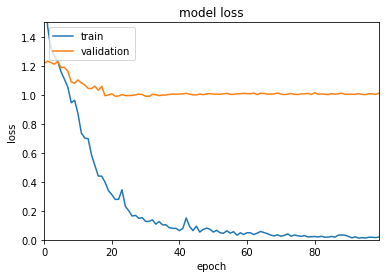

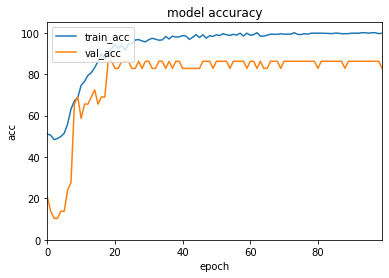

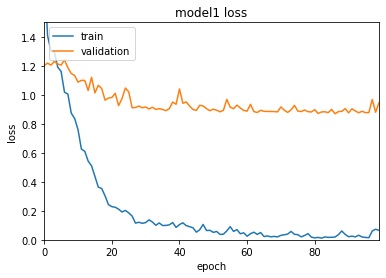

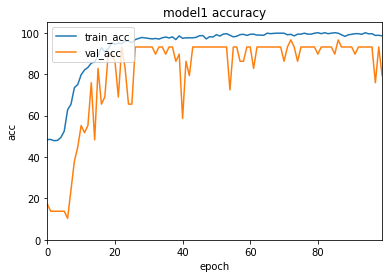

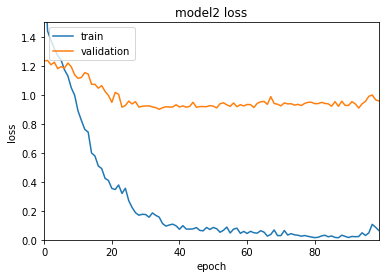

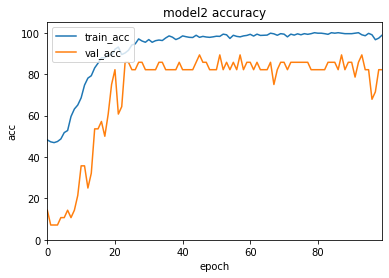

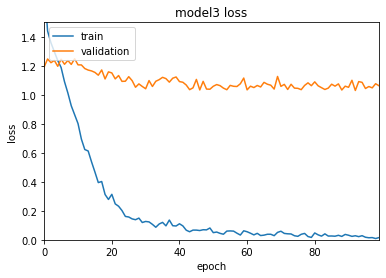

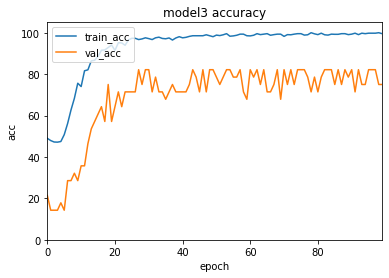

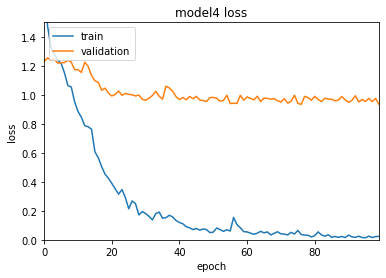

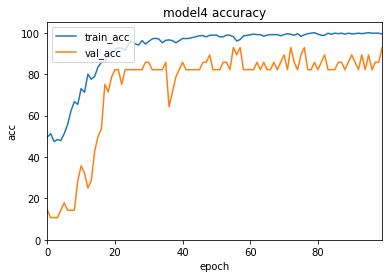

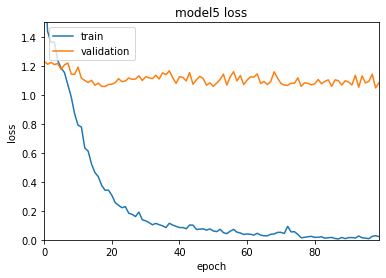

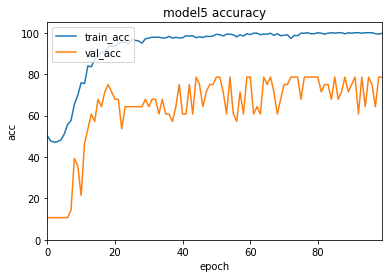

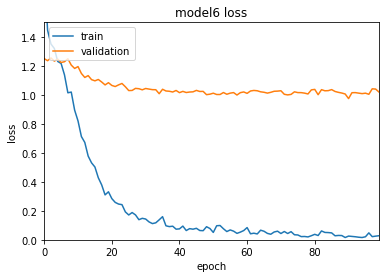

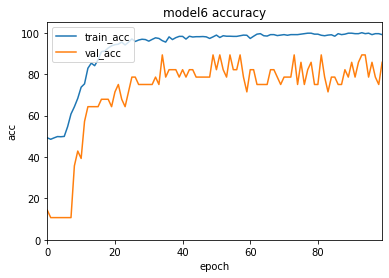

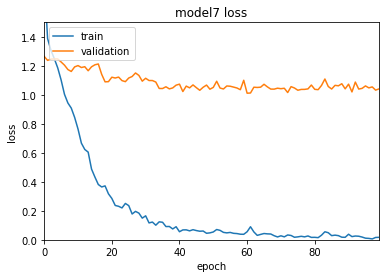

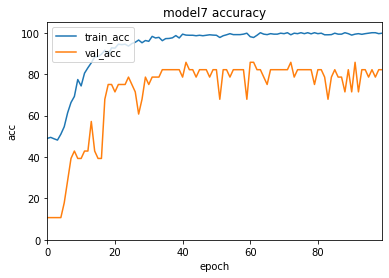

In [24]:
#Plotting loss
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss1)
plt.plot(val_loss1)
plt.title('model1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc1)
plt.plot(val_acc1)
plt.title('model1 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss2)
plt.plot(val_loss2)
plt.title('model2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc2)
plt.plot(val_acc2)
plt.title('model2 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss3)
plt.plot(val_loss3)
plt.title('model3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc3)
plt.plot(val_acc3)
plt.title('model3 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss4)
plt.plot(val_loss4)
plt.title('model4 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc4)
plt.plot(val_acc4)
plt.title('model4 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss5)
plt.plot(val_loss5)
plt.title('model5 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc5)
plt.plot(val_acc5)
plt.title('model5 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss6)
plt.plot(val_loss6)
plt.title('model6 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc6)
plt.plot(val_acc6)
plt.title('model6 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss7)
plt.plot(val_loss7)
plt.title('model7 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc7)
plt.plot(val_acc7)
plt.title('model7 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

Validation Accuracy |  82.75862068965517  PPV |  [0.88888889 0.        ]  Recall |  [0.92307692 0.        ]


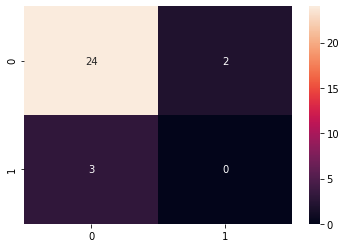

In [25]:
final_prediction = []
final_prediction_true = []

y_pred_list = []
test_loader = DataLoader(dataset=test_data, batch_size=1)
model.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_0, y_pred_list)
ppv = precision_score(testing_fold_Y_0, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_0, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_0, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_0:
    final_prediction_true.append(y)

Validation Accuracy |  79.3103448275862  PPV |  [0.95454545 0.28571429]  Recall |  [0.80769231 0.66666667]


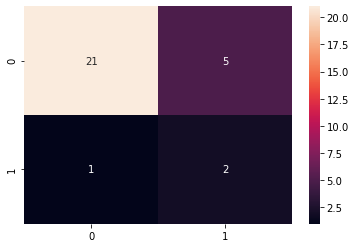

In [26]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data1, batch_size=1)
model1.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model1(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_1, y_pred_list)
ppv = precision_score(testing_fold_Y_1, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_1, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_1, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_1:
    final_prediction_true.append(y)

Validation Accuracy |  82.14285714285714  PPV |  [0.92 0.  ]  Recall |  [0.88461538 0.        ]


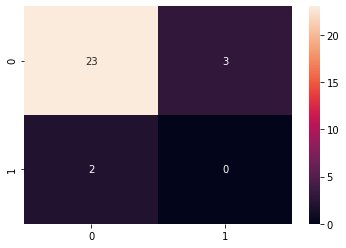

In [27]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data2, batch_size=1)
model2.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model2(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_2, y_pred_list)
ppv = precision_score(testing_fold_Y_2, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_2, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_2, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_2:
    final_prediction_true.append(y)

Validation Accuracy |  75.0  PPV |  [0.875 0.   ]  Recall |  [0.84 0.  ]


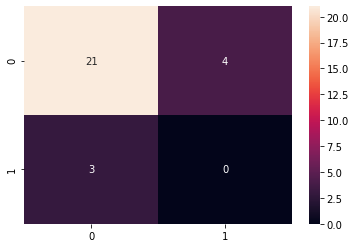

In [28]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data3, batch_size=1)
model3.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model3(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_3, y_pred_list)
ppv = precision_score(testing_fold_Y_3, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_3, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_3, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_3:
    final_prediction_true.append(y)

Validation Accuracy |  92.85714285714286  PPV |  [0.92592593 1.        ]  Recall |  [1.         0.33333333]


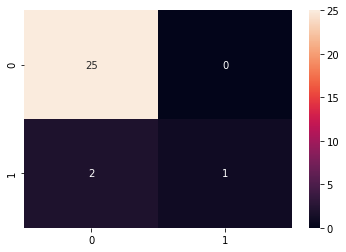

In [29]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data4, batch_size=1)
model4.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model4(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_4, y_pred_list)
ppv = precision_score(testing_fold_Y_4, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_4, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_4, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_4:
    final_prediction_true.append(y)

Validation Accuracy |  78.57142857142857  PPV |  [0.88 0.  ]  Recall |  [0.88 0.  ]


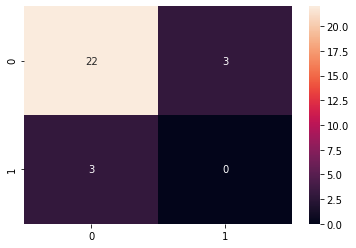

In [30]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data5, batch_size=1)
model5.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model5(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_5, y_pred_list)
ppv = precision_score(testing_fold_Y_5, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_5, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_5, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_5:
    final_prediction_true.append(y)

Validation Accuracy |  85.71428571428571  PPV |  [0.88888889 0.        ]  Recall |  [0.96 0.  ]


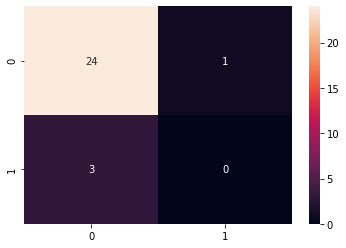

In [31]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data6, batch_size=1)
model6.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model6(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_6, y_pred_list)
ppv = precision_score(testing_fold_Y_6, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_6, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_6, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_6:
    final_prediction_true.append(y)

Validation Accuracy |  82.14285714285714  PPV |  [0.88461538 0.        ]  Recall |  [0.92 0.  ]


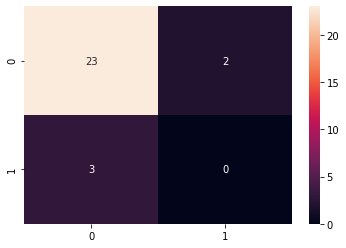

In [32]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data7, batch_size=1)
model7.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model7(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_7, y_pred_list)
ppv = precision_score(testing_fold_Y_7, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_7, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_7, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_7:
    final_prediction_true.append(y)

In [33]:
prediction_labels = []
true_labels = []

for x in range(0,len(final_prediction_true)):
    true_labels.append(final_prediction_true[x][0])
    prediction_labels.append(final_prediction[x][0][0])

prediction_labels

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0

[[183  20]
 [ 20   3]]
Positive Predictive Value tp/(tp+fp):  0.13043478260869565
Accuracy Value (tp+tn)/(tp+fp+fn+tn):  0.8230088495575221
Recall Value tp/(tp+fn):  0.13043478260869565


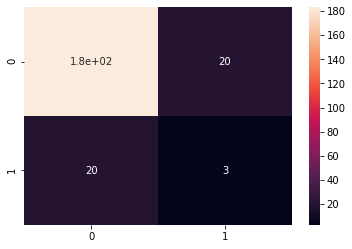

In [34]:
cf_matrix = confusion_matrix(true_labels, prediction_labels)
print(cf_matrix)
sn.heatmap(cf_matrix, annot=True)


accuracy = accuracy_score(true_labels, prediction_labels)
recall = recall_score(true_labels, prediction_labels, average=None)
prec_score = precision_score(true_labels, prediction_labels, average=None)
print('Positive Predictive Value tp/(tp+fp): ',prec_score[1]) 
print('Accuracy Value (tp+tn)/(tp+fp+fn+tn): ',accuracy) 
print('Recall Value tp/(tp+fn): ',recall[1]) 